In [3]:
import tensorflow as tf
import numpy as np
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [4]:
# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('paper')
%matplotlib inline

In [5]:
# Load the data
def loadData():
    with np.load("notMNIST.npz") as data:
        Data, Target = data["images"], data["labels"]
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx] / 255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:10000], Target[:10000]
        validData, validTarget = Data[10000:16000], Target[10000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

# Implementation of a neural network using only Numpy - trained using gradient descent with momentum
def convertOneHot(trainTarget, validTarget, testTarget):
    newtrain = np.zeros((trainTarget.shape[0], 10))
    newvalid = np.zeros((validTarget.shape[0], 10))
    newtest = np.zeros((testTarget.shape[0], 10))

    for item in range(0, trainTarget.shape[0]):
        newtrain[item][trainTarget[item]] = 1
    for item in range(0, validTarget.shape[0]):
        newvalid[item][validTarget[item]] = 1
    for item in range(0, testTarget.shape[0]):
        newtest[item][testTarget[item]] = 1
    return newtrain, newvalid, newtest


def shuffle(trainData, trainTarget):
    np.random.seed(421)
    randIndx = np.arange(len(trainData))
    target = trainTarget
    np.random.shuffle(randIndx)
    data, target = trainData[randIndx], target[randIndx]
    return data, target

In [6]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

# Training Data
X_train = np.reshape(trainData, (10000,784))

# Test Data
X_test = np.reshape(testData, (2724,784))

# Validation Data
X_validation = np.reshape(validData, (6000,784))

Y_train, Y_validation, Y_test = convertOneHot(trainTarget, validTarget, testTarget)

# Initial values
W_initial = np.ones([784, 1])
b_initial = 0
reg_param = 0

# Fix data sets for training later
setup_x_data = lambda x : np.expand_dims(x, axis=-1)
trainData_2 = setup_x_data(trainData)
validData_2 = setup_x_data(validData)
testData_2 = setup_x_data(testData)

### 1. Neural Networks using NumPy

#### 1.1 Helper Functions

In [7]:
def relu(x):
    return np.maximum(x, 0)

In [8]:
def softmax(x):
    # to avoid overflow, subtract x max from all elements
    largest = np.amax(x, axis=1, keepdims=True)
    x_new = np.subtract(x, largest)
     
    # softmax part
    expo = np.exp(x_new)
    expo_sum = np.sum(np.exp(x_new), axis=1, keepdims=True)
    return expo/expo_sum

In [9]:
def computeLayer(X, W, b):
    return np.add(np.matmul(X, W), b)

In [10]:
def averageCE(target, prediction):
    # TODO: add guards for prediction of 0
    return -np.mean(target*np.log(prediction))

In [11]:
def CE(target, prediction):
    return -target*np.log(prediction)

\begin{equation*}\\
Let\ \sigma(o_j)= \frac{e^{o_j}}{\sum_{k=1}^{K}e^{o_k}} for\ j=1....K\ for\ K\ classes
\end{equation*}
##### Derivative of softmax with respect to the input
###### if j = k:
\begin{align*}
\frac{\partial \sigma_{o_j}}{\partial o_j}\left[\frac{e^{o_j}}{\sum_{k=1}^{K}e^{o_k}}\right] &=
\frac{\frac{\partial}{\partial o_j}(e^{o_j})(\sum_{k=1}^{K}e^{o_k}) - \frac{\partial}{\partial o_j}(\sum_{k=1}^{K}e^{o_k})(e^{o_j})}{{(\sum_{k=1}^{K}e^{o_k})^2}} \\
&= \frac{e^{o_j}(\sum_{k=1}^{K}e^{o_k})-e^{o_j}e^{o_j}}{(\sum_{k=1}^{K}e^{o_k})^2}\\
&= \frac{e^{o_j}}{\sum_{k=1}^{K}e^{o_k}}\left[1-\frac{e^{o_j}}{\sum_{k=1}^{K}e^{o_k}}\right]\\
&= \sigma(o_j)(1-\sigma(o_j))
\end{align*}
###### if j $\neq$ k
\begin{align*}
\frac{\partial \sigma_{o_j}}{\partial o_k}\left[\frac{e^{o_j}}{\sum_{k=1}^{K}e^{o_k}}\right] &=
\frac{\partial}{\partial o_k}\left[e^{o_j}(\sum_{k=1}^{K}e^{o_k})^{-1}\right]\\
&= 0+\frac{e^{o_j}(-e^{o_k})}{(\sum_{k=1}^{K}e^{o_k})^2}\\
&= -\sigma(o_j)\sigma(o_k)
\end{align*}

#### Gradient of Cross Entropy loss with respect to softmax inputs
\begin{align*}
CE &= -\sum_{k=1}^{K}y_klog(\sigma(o_k))\\
\frac{\partial CE}{\partial o_j} &= -\sum_{k=1}^{K}y_k\frac{\partial}{\partial o_j}log(\sigma(o_k))\\
&= -sum_{k=1}^{K}y_k\left[\frac{1}{\sigma(o_k)}\frac{\partial \sigma(o_k)}{\partial o_j}\right]\\
&= \underbrace{-\frac{y_j}{\sigma(o_j)}\frac{\partial \sigma(o_j)}{\partial o_j}}_{where\ j=k} - \sum_{k=1,k \neq j}^{K}\frac{y_k}{\sigma(o_k)}
\frac{\partial \sigma(o_k)}{\partial o_j}\\
&= -\frac{y_j}{\sigma(o_j)}\sigma(o_j)(1-\sigma(o_j)) - \sum_{k=1,k \neq j}^{K}\frac{y_k}{\sigma(o_k)} -\sigma(o_j)\sigma(o_k)\\
&= -y_j + y_j \sigma(o_j) + \sum_{k=1,k \neq j}^{K} y_k \sigma(o_j)\\
&= -y_j + \sum_{k=1}^{K}y_k \sigma(o_j)\\
&= -y_j + \sigma(o_j)\underbrace{\sum_{k=1}^{K}y_k}_{ = 1}\\
&= -y_j + \sigma(o_j)\\
&= -y_j + p_j\ [*]
\end{align*}

In [12]:
def gradCE(target, prediction):
    return -target + prediction

### 1.2 Backpropogation Derivation

\begin{equation*}\\
Let\ \sigma(o_j)= \frac{e^{o_j}}{\sum_{k=1}^{K}e^{o_k}} for\ j=1....K\ for\ K\ classes\\
L = -\sum_{k=1}^{K}y_klog(p_k)\\
\end{equation*}

Step 1: Gradient of Loss w.r.t. outer layer weights
\begin{align*}
\frac{\partial L }{\partial b_o} &= \frac{\partial L }{\partial O} \cdot \frac{\partial O }{\partial w_o}\\
Using\ equation\ *, \frac{\partial L }{\partial O} &= -y_j + \sigma(O)\ and\ by\ inspection, \frac{\partial O }{\partial w_o} = h\\
\implies \frac{\partial L }{\partial w_o} &= h(p_k - y_k)
\end{align*}

Step 2: Gradient of Loss w.r.t. outer layer bias
\begin{align*}
\frac{\partial L }{\partial b_o} &= \frac{\partial L }{\partial O} \cdot \frac{\partial O }{\partial b_o}\\
Using\ equation\ *, \frac{\partial L }{\partial O} &= -y_j + \sigma(O)\ and\ by\ inspection, \frac{\partial O }{\partial b_o} = 1\\
\implies \frac{\partial L }{\partial b_o} &= (p_k - y_k)
\end{align*}

Step 3: Gradient of Loss w.r.t. hidden layer weights
\begin{align*}
Let\ h_s &= W_hx + b_h\\
\frac{\partial L }{\partial W_h} &= \frac{\partial L }{\partial O} \cdot \frac{\partial O }{\partial h} \cdot \frac{\partial h }{\partial h_s} \cdot \frac{\partial h_s }{\partial W_h}\\
Using\ equation\ *, \frac{\partial L }{\partial O} &= -y_j + p_k\\
By\ inspection\ \frac{\partial h_s }{\partial W_h} &= x\ and\ \frac{\partial O }{\partial h} = W_o\\
\frac{\partial h }{\partial h_s} &= \frac{\partial \text{ReLU}(h_s) }{\partial h_s} = \begin{cases}
1,\ h_s \gt 0\\
0,\ h_s \lt 0
\end{cases}\\
\implies \frac{\partial L }{\partial W_h} &= \begin{cases}
(p_k - y)W_ox,\ h_s \gt 0\\
0,\ h_s \lt 0
\end{cases}\\
\end{align*}

Step 4: Gradient of Loss w.r.t. hidden layer bias
\begin{align*}
Let\ h_s &= W_hx + b_h\\
\frac{\partial L }{\partial b_h} &= \frac{\partial L }{\partial O} \cdot \frac{\partial O }{\partial h} \cdot \frac{\partial h }{\partial h_s} \cdot \frac{\partial h_s }{\partial b_h}\\
Using\ equation\ *, \frac{\partial L }{\partial O} &= -y_j + p_k\\
By\ inspection\ \frac{\partial h_s }{\partial b_h} &= 1\ and\ \frac{\partial O }{\partial h} = W_o\\
\frac{\partial h }{\partial h_s} &= \frac{\partial \text{ReLU}(h_s) }{\partial h_s} = \begin{cases}
1,\ h_s \gt 0\\
0,\ h_s \lt 0
\end{cases}\\
\implies \frac{\partial L }{\partial b_h} &= \begin{cases}
(p_k - y)W_o,\ h_s \gt 0\\
0,\ h_s \lt 0
\end{cases}\\
\end{align*}

In [13]:
def outer_layer_weights_grad(h, prediction, y):
    return np.matmul(np.transpose(h), gradCE(y, prediction))

def outer_layer_bias_grad(prediction, y):
    return np.matmul(np.ones((1, y.shape[0])), gradCE(y, prediction))

def hidden_layer_weights_grad(prediction, y, output_weights, inputs, h):
    potential_out = np.matmul(gradCE(y, prediction), np.transpose(output_weights))
    return np.matmul(np.transpose(inputs), np.where(h > 0, potential_out, 0))

def hidden_layer_bias_grad(prediction, y, output_weights, inputs, h):
    potential_out = np.matmul(gradCE(y, prediction), np.transpose(output_weights))
    return np.matmul(np.ones((1, y.shape[0])), np.where(h > 0, potential_out, 0))

#### 1.3 Learning 

In [20]:
def training(x_train, y_train, x_val=None, y_val=None, x_test=None, y_test=None, h_units:int=1000):
    
    hidden_units = h_units
    num_epochs = 200
    
    # make sure its consistent for testing purposes
    np.random.seed(421)
    # initialize weights and biases for the layers
    W1 = np.random.normal(loc=0, scale=np.sqrt(2/(784+hidden_units)), size=(784,hidden_units))
    b1 = np.zeros([1, hidden_units])
    W2 = np.random.normal(loc=0, scale=np.sqrt(2/(hidden_units+10)),  size=(hidden_units,10))
    b2 = np.zeros([1, 10])
    
    gamma = 0.9
    alpha = 1e-5
    
    v_w1 = np.ones([784, hidden_units]) * 1e-5
    v_w2 = np.ones([hidden_units, 10]) * 1e-5
    v_b1 = b1
    v_b2 = b2
    
    train_loss, val_loss, test_loss = [], [], []
    train_acc, val_acc, test_acc = [], [], []
    
    for epoch in range(num_epochs):
        print("Iteration:", epoch)
        # Forward pass
        # for training
        h_in = computeLayer(x_train, W1, b1)
        h_out = relu(h_in)
        p = softmax(computeLayer(h_out, W2, b2))
        
        train_loss.append(averageCE(y_train, p))
        train_acc.append(getAccuracy(y_train, p))
        
        # for validation
        if x_val is not None and y_val is not None:
            loss, acc = evalForwardPass(x_val, y_val, W1, b1, W2, b2)
            val_loss.append(loss)
            val_acc.append(acc)
            
        # for test
        if x_test is not None and y_test is not None:
            loss, acc = evalForwardPass(x_test, y_test, W1, b1, W2, b2)
            test_loss.append(loss)
            test_acc.append(acc)
        
        # back propogation
        # through outer layer
        v_w2 = gamma*v_w2 + alpha*outer_layer_weights_grad(h_out, p, y_train)
        W2 = W2 - v_w2
        
        v_b2 = gamma*v_b2 + alpha*outer_layer_bias_grad(p, y_train)
        b2 = b2 - v_b2
        
        # through hidden layer
        v_w1 = gamma*v_w1 + alpha*hidden_layer_weights_grad(p, y_train, W2, x_train, h_in)
        W1 = W1 - v_w1
        
        v_b1 = gamma*v_b1 + alpha*hidden_layer_bias_grad(p, y_train, W2, x_train, h_in)
        b1 = b1 - v_b1
        
        
    return train_loss, val_loss, test_loss, train_acc, val_acc, test_acc
   

In [15]:
def getAccuracy(target, prediction):
    # max value amongst the 10 categories is the prediction
    target_index = np.argmax(target, axis=1)
    pred_index = np.argmax(prediction, axis=1)
    
    # compare the predictions
    acc = np.sum(target_index == pred_index)/prediction.shape[0]

    print(acc)
    return acc

In [16]:
def evalForwardPass(x, y, W1, b1, W2, b2):
    # forward pass
    h = relu(computeLayer(x, W1, b1))
    p = softmax(computeLayer(h, W2, b2))

    # compute loss and acc
    loss = averageCE(y, p)
    acc = getAccuracy(y, p)

    return loss, acc

In [21]:
train_loss, val_loss, test_loss, train_acc, val_acc, test_acc = training(X_train, Y_train, X_validation, Y_validation, X_test, Y_test)

Iteration: 0
0.0847
0.08133333333333333
0.08296622613803231
Iteration: 1
0.2877
0.26416666666666666
0.2881791483113069
Iteration: 2
0.7091
0.6988333333333333
0.7052129221732746
Iteration: 3
0.7465
0.7388333333333333
0.7507342143906021
Iteration: 4
0.8099
0.809
0.8197503671071953
Iteration: 5
0.8327
0.8293333333333334
0.8406754772393539
Iteration: 6
0.8435
0.8448333333333333
0.8535242290748899
Iteration: 7
0.8497
0.8505
0.8579295154185022
Iteration: 8
0.8562
0.8546666666666667
0.8604992657856094
Iteration: 9
0.8581
0.854
0.8641703377386197
Iteration: 10
0.8656
0.8613333333333333
0.8766519823788547
Iteration: 11
0.87
0.8653333333333333
0.8718795888399412
Iteration: 12
0.8726
0.8668333333333333
0.8762848751835536
Iteration: 13
0.8735
0.8666666666666667
0.8770190895741556
Iteration: 14
0.8772
0.8685
0.881424375917768
Iteration: 15
0.8808
0.8736666666666667
0.8832599118942731
Iteration: 16
0.883
0.8761666666666666
0.8821585903083701
Iteration: 17
0.8837
0.8763333333333333
0.8847283406754772

Iteration: 151
0.9603
0.9045
0.9074889867841409
Iteration: 152
0.9607
0.9045
0.9074889867841409
Iteration: 153
0.961
0.9045
0.9074889867841409
Iteration: 154
0.9611
0.9046666666666666
0.9074889867841409
Iteration: 155
0.9618
0.9046666666666666
0.9074889867841409
Iteration: 156
0.962
0.9048333333333334
0.9074889867841409
Iteration: 157
0.9623
0.905
0.9074889867841409
Iteration: 158
0.9628
0.905
0.907856093979442
Iteration: 159
0.9631
0.9051666666666667
0.907856093979442
Iteration: 160
0.9635
0.905
0.907856093979442
Iteration: 161
0.9639
0.9051666666666667
0.907856093979442
Iteration: 162
0.9644
0.905
0.907856093979442
Iteration: 163
0.9648
0.9051666666666667
0.907856093979442
Iteration: 164
0.9653
0.9055
0.907856093979442
Iteration: 165
0.9657
0.9056666666666666
0.9085903083700441
Iteration: 166
0.9659
0.9056666666666666
0.9085903083700441
Iteration: 167
0.966
0.9056666666666666
0.9085903083700441
Iteration: 168
0.9664
0.9053333333333333
0.9085903083700441
Iteration: 169
0.9666
0.905333

In [22]:
def print_plots(train_loss, val_loss, test_loss, train_acc, val_acc, test_acc, name=''):
    # Plot Losses
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.plot(test_loss)
    plt.title('Losses for Data Sets After Each Epoch' + name)
    plt.legend(['Training Set', 'Validation Set', 'Testing Set'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch Number')
    plt.show()

    # Plot Accuracy
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.plot(test_acc)
    plt.title('Accuracy for Data Sets After Each Epoch' + name)
    plt.legend(['Training Set', 'Validation Set', 'Testing Set'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch Number')
    plt.show()

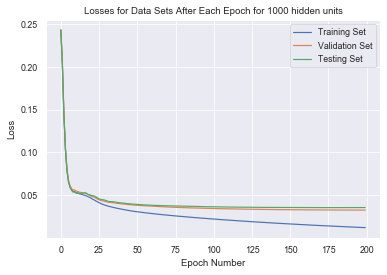

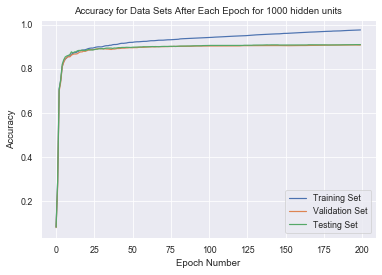

In [23]:
print_plots(train_loss, val_loss, test_loss, train_acc, val_acc, test_acc, name=' for 1000 hidden units')

The plot shows, as expected, an increase in the accuracy and decrease in the loss as the neural network is trained. However, there is a point at which the testing and validation loss flatten, but the training loss diverges and continue to decrease. This is likely due to overfitting, as the model continues to improve its performance on the training set, but those improvements do not generalize to the unseen data sets.


#### 1.4 Hyperparameter Investigation

    1. Number of hidden units

In [24]:
train_loss_100, val_loss_100, test_loss_100, train_acc_100, val_acc_100, test_acc_100 = training(X_train, Y_train, X_validation, Y_validation, X_test, Y_test, h_units=100)

Iteration: 0
0.0998
0.09783333333333333
0.09691629955947137
Iteration: 1
0.1356
0.128
0.13105726872246695
Iteration: 2
0.3702
0.36083333333333334
0.3696769456681351
Iteration: 3
0.5694
0.563
0.5745227606461086
Iteration: 4
0.6297
0.6311666666666667
0.6336270190895742
Iteration: 5
0.6939
0.695
0.7008076358296622
Iteration: 6
0.7684
0.77
0.7790014684287812
Iteration: 7
0.7806
0.7741666666666667
0.7900146842878121
Iteration: 8
0.8265
0.8225
0.8270925110132159
Iteration: 9
0.823
0.8211666666666667
0.8263582966226138
Iteration: 10
0.8436
0.8453333333333334
0.8505873715124816
Iteration: 11
0.8474
0.845
0.8480176211453745
Iteration: 12
0.8522
0.8505
0.8593979441997063
Iteration: 13
0.8558
0.8553333333333333
0.8652716593245228
Iteration: 14
0.8597
0.8595
0.867474302496329
Iteration: 15
0.8644
0.8616666666666667
0.8715124816446402
Iteration: 16
0.8654
0.8615
0.8700440528634361
Iteration: 17
0.8671
0.8616666666666667
0.867474302496329
Iteration: 18
0.8696
0.8653333333333333
0.8707782672540382
It

0.9379
0.9043333333333333
0.9052863436123348
Iteration: 149
0.938
0.9046666666666666
0.9052863436123348
Iteration: 150
0.9378
0.9045
0.9052863436123348
Iteration: 151
0.9381
0.9046666666666666
0.9056534508076358
Iteration: 152
0.9384
0.9045
0.9056534508076358
Iteration: 153
0.9385
0.9046666666666666
0.9052863436123348
Iteration: 154
0.9387
0.9048333333333334
0.9052863436123348
Iteration: 155
0.9389
0.9048333333333334
0.9056534508076358
Iteration: 156
0.939
0.9048333333333334
0.9056534508076358
Iteration: 157
0.9392
0.9046666666666666
0.9052863436123348
Iteration: 158
0.94
0.9048333333333334
0.9052863436123348
Iteration: 159
0.9401
0.9048333333333334
0.9052863436123348
Iteration: 160
0.94
0.905
0.9056534508076358
Iteration: 161
0.9402
0.9048333333333334
0.9060205580029369
Iteration: 162
0.9407
0.905
0.9060205580029369
Iteration: 163
0.9407
0.9048333333333334
0.9056534508076358
Iteration: 164
0.9412
0.9048333333333334
0.9056534508076358
Iteration: 165
0.9415
0.9048333333333334
0.90565345

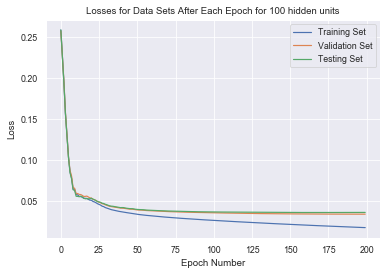

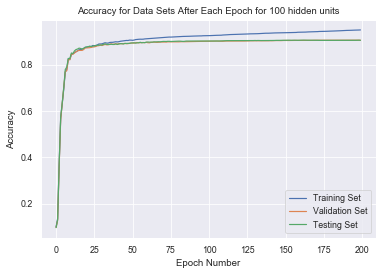

In [26]:
print_plots(train_loss_100, val_loss_100, test_loss_100, train_acc_100, val_acc_100, test_acc_100, name=' for 100 hidden units')

In [31]:
print("Final test accuracy:", test_acc_100[-1])

Final test accuracy: 0.9052863436123348


In [27]:
train_loss_500, val_loss_500, test_loss_500, train_acc_500, val_acc_500, test_acc_500 = training(X_train, Y_train, X_validation, Y_validation, X_test, Y_test, h_units=500)

Iteration: 0
0.0827
0.081
0.08186490455212922
Iteration: 1
0.2334
0.239
0.2301762114537445
Iteration: 2
0.5813
0.5866666666666667
0.580029368575624
Iteration: 3
0.7152
0.7088333333333333
0.7151248164464024
Iteration: 4
0.8008
0.786
0.802496328928047
Iteration: 5
0.8293
0.8255
0.8370044052863436
Iteration: 6
0.843
0.8395
0.8483847283406755
Iteration: 7
0.8442
0.8425
0.8520558002936858
Iteration: 8
0.852
0.8483333333333334
0.8564610866372981
Iteration: 9
0.859
0.8591666666666666
0.8671071953010279
Iteration: 10
0.8604
0.8603333333333333
0.8660058737151248
Iteration: 11
0.8631
0.8608333333333333
0.8645374449339207
Iteration: 12
0.8685
0.8653333333333333
0.8722466960352423
Iteration: 13
0.8707
0.8693333333333333
0.8751835535976505
Iteration: 14
0.8734
0.87
0.8751835535976505
Iteration: 15
0.8767
0.8751666666666666
0.8792217327459618
Iteration: 16
0.8772
0.8741666666666666
0.8777533039647577
Iteration: 17
0.8779
0.873
0.8762848751835536
Iteration: 18
0.8786
0.874
0.881791483113069
Iteration

0.9071666666666667
0.9045521292217328
Iteration: 151
0.9534
0.9071666666666667
0.9045521292217328
Iteration: 152
0.9538
0.9073333333333333
0.9045521292217328
Iteration: 153
0.954
0.9075
0.9045521292217328
Iteration: 154
0.954
0.9075
0.9045521292217328
Iteration: 155
0.9544
0.9078333333333334
0.9045521292217328
Iteration: 156
0.9547
0.908
0.9045521292217328
Iteration: 157
0.9552
0.9081666666666667
0.9045521292217328
Iteration: 158
0.9558
0.9085
0.9045521292217328
Iteration: 159
0.9559
0.9086666666666666
0.9045521292217328
Iteration: 160
0.9563
0.9085
0.9045521292217328
Iteration: 161
0.9569
0.9085
0.9045521292217328
Iteration: 162
0.9569
0.9086666666666666
0.9041850220264317
Iteration: 163
0.957
0.9086666666666666
0.9041850220264317
Iteration: 164
0.9571
0.9088333333333334
0.9041850220264317
Iteration: 165
0.9573
0.9088333333333334
0.9045521292217328
Iteration: 166
0.9574
0.9088333333333334
0.9045521292217328
Iteration: 167
0.9577
0.909
0.9049192364170338
Iteration: 168
0.9584
0.9091666

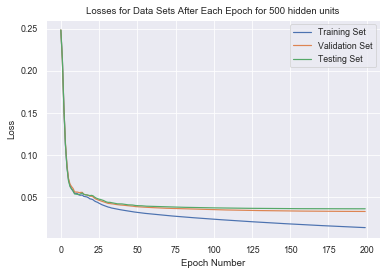

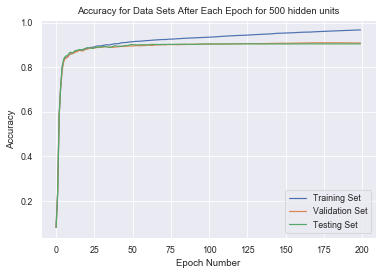

In [28]:
print_plots(train_loss_500, val_loss_500, test_loss_500, train_acc_500, val_acc_500, test_acc_500, name=' for 500 hidden units')

In [32]:
print("Final test accuracy:", test_acc_500[-1])

Final test accuracy: 0.9045521292217328


In [29]:
train_loss_2000, val_loss_2000, test_loss_2000, train_acc_2000, val_acc_2000, test_acc_2000 = training(X_train, Y_train, X_validation, Y_validation, X_test, Y_test, h_units=2000)

Iteration: 0
0.1263
0.11383333333333333
0.11894273127753303
Iteration: 1
0.3762
0.37416666666666665
0.36930983847283405
Iteration: 2
0.7197
0.7048333333333333
0.7202643171806168
Iteration: 3
0.8172
0.8115
0.8124082232011748
Iteration: 4
0.8241
0.8201666666666667
0.8267254038179148
Iteration: 5
0.8463
0.8435
0.8524229074889867
Iteration: 6
0.8507
0.846
0.8531571218795888
Iteration: 7
0.8543
0.8528333333333333
0.8627019089574156
Iteration: 8
0.8608
0.8575
0.8641703377386197
Iteration: 9
0.8658
0.8606666666666667
0.8660058737151248
Iteration: 10
0.8693
0.8626666666666667
0.8711453744493393
Iteration: 11
0.8718
0.8671666666666666
0.8751835535976505
Iteration: 12
0.8734
0.8685
0.8788546255506607
Iteration: 13
0.8761
0.8693333333333333
0.8803230543318649
Iteration: 14
0.8797
0.87
0.8821585903083701
Iteration: 15
0.8832
0.8748333333333334
0.882525697503671
Iteration: 16
0.884
0.8761666666666666
0.8854625550660793
Iteration: 17
0.8856
0.8783333333333333
0.8843612334801763
Iteration: 18
0.8868


Iteration: 151
0.9628
0.9065
0.9085903083700441
Iteration: 152
0.9632
0.9065
0.9085903083700441
Iteration: 153
0.9635
0.9065
0.9085903083700441
Iteration: 154
0.9642
0.9065
0.9085903083700441
Iteration: 155
0.9648
0.9066666666666666
0.9085903083700441
Iteration: 156
0.9651
0.9066666666666666
0.908223201174743
Iteration: 157
0.9656
0.9066666666666666
0.908223201174743
Iteration: 158
0.9659
0.9066666666666666
0.908223201174743
Iteration: 159
0.9659
0.9066666666666666
0.9085903083700441
Iteration: 160
0.9665
0.9068333333333334
0.9085903083700441
Iteration: 161
0.9668
0.9065
0.908957415565345
Iteration: 162
0.9673
0.9065
0.9085903083700441
Iteration: 163
0.9677
0.9065
0.9085903083700441
Iteration: 164
0.9681
0.9066666666666666
0.9085903083700441
Iteration: 165
0.9684
0.907
0.9085903083700441
Iteration: 166
0.969
0.9071666666666667
0.9085903083700441
Iteration: 167
0.9691
0.9075
0.9085903083700441
Iteration: 168
0.9693
0.9075
0.9085903083700441
Iteration: 169
0.9697
0.9075
0.908957415565345

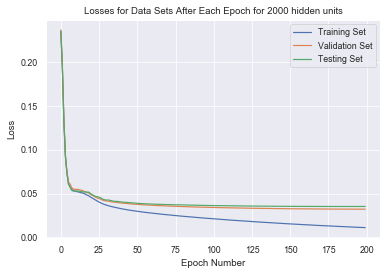

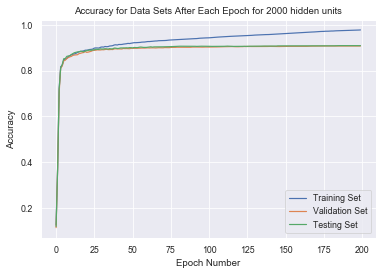

In [30]:
print_plots(train_loss_2000, val_loss_2000, test_loss_2000, train_acc_2000, val_acc_2000, test_acc_2000, name=' for 2000 hidden units')

In [33]:
print("Final test accuracy:", test_acc_2000[-1])

Final test accuracy: 0.9096916299559471


Observations: There is no significant benefit to a larger number of hidden units (final unseen test accuracies are within a fraction of a percentage point, 90.52% for 100 vs 90.96% for 2000). However, the increase in the number of hidden units significantly increases the training time.

    2. Early Stopping

In [61]:
test_min_index = np.argmin(test_loss)
val_min_index = np.argmin(val_loss)
test_max_index = np.argmax(test_acc)
val_max_index = np.argmax(val_acc)
print("Minimum test loss occurs at epoch", test_min_index)
print("Minimum validation loss occurs at epoch", val_min_index)
print("Maximum test accuracy occurs at epoch", test_max_index)
print("Maximum validation accuracy occurs at epoch", val_max_index)

Minimum test loss occurs at epoch 174
Minimum validation loss occurs at epoch 199
Maximum test accuracy occurs at epoch 195
Maximum validation accuracy occurs at epoch 195


In [57]:
delta = 0.00001
prev = test_loss[0]
for i in range(len(test_loss)):
    if i == 0: continue
    diff = abs(prev - test_loss[i])
    if diff < delta:
        print(i)
        break
    
    prev = test_loss[i]

33


In [58]:
delta = 0.00001
prev = test_acc[0]
for i in range(len(test_acc)):
    if i == 0: continue
    diff = abs(prev - test_acc[i])
    if diff < delta:
        print(i)
        break
    
    prev = test_acc[i]

24


In [63]:
print("Training accuracy at epoch 33:", train_acc[33])
print("Validation accuracy at epoch 33:", val_acc[33])
print("Testing accuracy at epoch 33:", test_acc[33])

Training accuracy at epoch 33: 0.9064
Validation accuracy at epoch 33: 0.8885
Testing accuracy at epoch 33: 0.8935389133627019


(Note: The numbers in this section e.g. epoch with lowest loss are all taken from the end of section 1.3)

   The early stopping point would be around the 25-35th epoch. We selected 33 since it was the point where the accuracy had already plateaued and the loss was no longer significantly improving.

   The epoch with the lowest training and validation loss is around 175-199; however, the improvements in accuracy get very small long before this. From above, the point at which the accuracy improvements become less than one-thousandth of a percent is the 24th epoch. The point at which loss improvements slow down similiarily is the 33rd epoch. Thus, the subsequent training is only of limited utility and it is possible to stop early around this point.

### 2. Neural Networks in Tensorflow

#### 2.1 Model Implementation

In [18]:
from tensorflow.keras import models, layers, activations, initializers, optimizers, losses, regularizers

def my_custom_nn_model(l2_weight_decy_coeff: float = None, dropout_rate: float = None):    
    model = models.Sequential()
    # glorot_normal is the keras version of Xavier scheme
    model.add(layers.Conv2D(filters=32, kernel_size=3, strides=[1,1], padding="same", 
                            kernel_initializer='glorot_normal',
                            input_shape=(28 , 28, 1)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=2, padding="same"))
    model.add(layers.Flatten())
    if l2_weight_decy_coeff is None:
        model.add(layers.Dense(units=784, kernel_initializer='glorot_normal'))
        if dropout_rate is not None:
            model.add(layers.Dropout(dropout_rate))
        model.add(layers.Activation('relu'))
        model.add(layers.Dense(units=10, kernel_initializer='glorot_normal'))
        model.add(layers.Activation('softmax'))
    else:
        model.add(layers.Dense(units=784, kernel_initializer='glorot_normal', 
                               kernel_regularizer=regularizers.l2(l2_weight_decy_coeff)))
        if dropout_rate is not None:
            model.add(layers.Dropout(dropout_rate))
        model.add(layers.Activation('relu'))
        model.add(layers.Dense(units=10, kernel_initializer='glorot_normal', 
                               kernel_regularizer=regularizers.l2(l2_weight_decy_coeff)))
        model.add(layers.Activation('softmax'))
    
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    print(model.summary())
    
    return model
    

In [19]:
# Check model creation
testModel = my_custom_nn_model()
testModel = None

W1109 17:38:38.103754 19860 deprecation.py:506] From C:\Users\Aleksei\Anaconda3\envs\ece421\lib\site-packages\tensorflow\python\ops\init_ops.py:1288: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 784)               4918032   
_________________________________________________________________
activation_1 (Activation)    (None, 784)               0

#### 2.2 Model Training

In [28]:
from tensorflow.keras import callbacks

class TestingDuringTrainingCallback(callbacks.Callback):
    eval_acc = list()
    eval_loss = list()
    
    def on_train_begin(self, logs=None):
        if len(self.eval_acc) != 0:
            self.eval_acc = list()
        if len(self.eval_loss) != 0:
            self.eval_loss = list()
    
    def on_epoch_end(self, epoch, logs=None):
        t = self.model.evaluate(testData_2, Y_test, batch_size=32)
        self.eval_loss.append(t[0])
        self.eval_acc.append(t[1])
        

def train_nn_model(model):
    # Train model, pausing after each epoch to collect test, validation, and training losses and accuracy
    hist = model.fit(trainData_2, Y_train, validation_data=(validData_2, Y_validation), epochs=50, batch_size=32, 
                     shuffle=True, callbacks=[TestingDuringTrainingCallback()])
    
    train_loss = np.array(hist.history['loss'])
    train_acc = np.array(hist.history['acc'])
    valid_loss = np.array(hist.history['val_loss'])
    valid_acc = np.array(hist.history['val_acc'])
    test_loss = np.array(TestingDuringTrainingCallback.eval_loss)
    test_acc = np.array(TestingDuringTrainingCallback.eval_acc)

    return model.get_weights(), train_loss, valid_loss, test_loss, train_acc, valid_acc, test_acc

def train_nn_model_no_logging(model):
    hist = model.fit(trainData_2, Y_train, validation_data=(validData_2, Y_validation), initial_epoch = 0, epochs=50, batch_size=32, shuffle=True)
    t = model.evaluate(testData_2, Y_test, batch_size=32)
    return model.get_weights(), (hist.history, t)

In [29]:
# Prepare model
model = my_custom_nn_model()

# Train the Network and collect loss information
weights, training_loss, validation_loss,testing_loss, training_accuracy, validation_accuracy, testing_accuracy = train_nn_model(model)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_6 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)               4918032   
_________________________________________________________________
activation_7 (Activation)    (None, 784)              

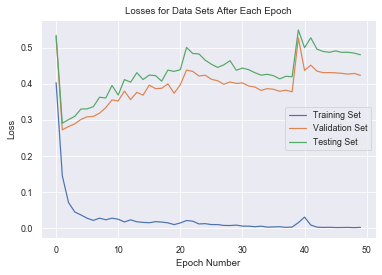

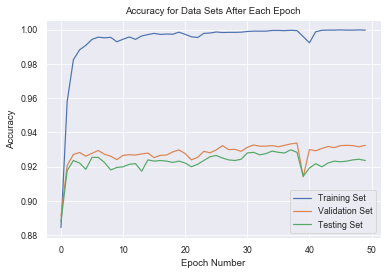

In [30]:
# Plot Losses
plt.plot(training_loss)
plt.plot(validation_loss)
plt.plot(testing_loss)
plt.title('Losses for Data Sets After Each Epoch')
plt.legend(['Training Set', 'Validation Set', 'Testing Set'])
plt.ylabel('Loss')
plt.xlabel('Epoch Number')
plt.show()

# Plot Accuracy
plt.plot(training_accuracy)
plt.plot(validation_accuracy)
plt.plot(testing_accuracy)
plt.title('Accuracy for Data Sets After Each Epoch')
plt.legend(['Training Set', 'Validation Set', 'Testing Set'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch Number')
plt.show()

The loss graph shows a rapid decay in training loss, which then flattens out. The Accuracy also shows a quick spike before flattening. However, the model quickly reaches a point where the accuracy on the training set is almost 100%, but the accuracy on the training and validation sets remains at a constant high value, of approximately 93%.

#### 2.3 Hyperparameter Investigation

##### 1. L2  Normalization

In [31]:
losses = list()
validation_losses = list()
test_losses = list()
accuracies = list()
validation_accuracies = list()
test_accuracies = list()
l2_values_list = [0.01, 0.1, 0.5]

# Train model and collect losses and accuracies
for l2_val in l2_values_list:
    model = my_custom_nn_model(l2_weight_decy_coeff=l2_val)
    weights, a = train_nn_model_no_logging(model)
    losses.append(np.array(a[0]['loss']))
    accuracies.append(np.array(a[0]['acc']))
    validation_losses.append(np.array(a[0]['val_loss']))
    validation_accuracies.append(np.array(a[0]['val_acc']))
    test_losses.append(a[1][0])
    test_accuracies.append(a[1][1])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_9 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 784)               4918032   
_________________________________________________________________
activation_10 (Activation)   (None, 784)              

10000/10000 [==============================] - 10s 1ms/sample - loss: 0.5021 - acc: 0.9294 - val_loss: 0.5312 - val_acc: 0.9207
Epoch 44/50
10000/10000 [==============================] - 10s 998us/sample - loss: 0.4977 - acc: 0.9299 - val_loss: 0.5275 - val_acc: 0.9193
Epoch 45/50
10000/10000 [==============================] - 10s 1ms/sample - loss: 0.4930 - acc: 0.9290 - val_loss: 0.5282 - val_acc: 0.9232
Epoch 46/50
10000/10000 [==============================] - 10s 1ms/sample - loss: 0.4893 - acc: 0.9318 - val_loss: 0.5228 - val_acc: 0.9213
Epoch 47/50
10000/10000 [==============================] - 10s 1ms/sample - loss: 0.4882 - acc: 0.9313 - val_loss: 0.5231 - val_acc: 0.9200
Epoch 48/50
10000/10000 [==============================] - 10s 1ms/sample - loss: 0.4856 - acc: 0.9331 - val_loss: 0.5173 - val_acc: 0.9233
Epoch 49/50
10000/10000 [==============================] - 10s 1ms/sample - loss: 0.4804 - acc: 0.9356 - val_loss: 0.5130 - val_acc: 0.9227
Epoch 50/50
2724/2724 [=======

In [32]:
# Print normalization results
for idx, val in enumerate(l2_values_list):
    print('For lambda= ' + str(val))
    print('Final Losses: ' +
          'Training - ' + str(losses[idx][-1]) +
          ' Validation '  + str(validation_losses[idx][-1]) +
          ' Test '  + str(test_losses[idx]))
    print('Final Accuracies: ' + 
          'Training - ' + str(accuracies[idx][-1]) +
          ' Validation '  + str(validation_accuracies[idx][-1]) +
          ' Test '  + str(test_accuracies[idx]))

For lambda= 0.01
Final Losses: Training - 0.17910743565559387 Validation 0.3535492696762085 Test 0.38028199587799555
Final Accuracies: Training - 0.9872 Validation 0.93416667 Test 0.93024963
For lambda= 0.1
Final Losses: Training - 0.47838789987564084 Validation 0.5147415553728739 Test 0.5129216408764563
Final Accuracies: Training - 0.9342 Validation 0.91816664 Test 0.9236417
For lambda= 0.5
Final Losses: Training - 0.908181247997284 Validation 0.9236387405395508 Test 0.9158293360655528
Final Accuracies: Training - 0.8964 Validation 0.8976667 Test 0.8957416


| Regularization Parameter Value ($\lambda$) | Final Training Accuracy (%) | Final Validation Accuracy (%) | Final Testing Accuracy (%) |
| :----------------------------------------: | :-------------------------: | :---------------------------: | :------------------------: |
|                    0.01                    |            98.72            |             93.42             |           93.02            |
|                    0.1                     |            93.42            |             91.82             |           92.36            |
|                    0.5                     |            89.64            |             89.77             |           89.57            |

L2 regularization decreases accuracies for the test and validation set as it gets larger. As the regularization gets larger, larger weights are punished more. However, a "good" model may require larger weights and penalizing it too much will result in losses, as we see in the table.

##### 2. Dropout

In [33]:
losses = list()
accuracies = list()
dropout_list = [0.9, 0.75, 0.5]

# Train model and collect losses and accuracies
for dropout_val in dropout_list:
    model = my_custom_nn_model(dropout_rate=dropout_val)
    weights, l1, l2, l3, a1, a2, a3 = train_nn_model(model)
    losses.append((l1, l2, l3))
    accuracies.append((a1, a2, a3))

W1109 18:11:02.563211 19860 nn_ops.py:4224] Large dropout rate: 0.9 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_18 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 784)               4918032   
_________________________________________________________________
dropout (Dropout)            (None, 784)              

Epoch 29/50
10000/10000 [==============================] - 8s 848us/sample - loss: 0.1712 - acc: 0.9461 - val_loss: 0.2443 - val_acc: 0.9368
Epoch 30/50
10000/10000 [==============================] - 8s 845us/sample - loss: 0.1645 - acc: 0.9463 - val_loss: 0.2480 - val_acc: 0.9362
Epoch 31/50
10000/10000 [==============================] - 8s 844us/sample - loss: 0.1598 - acc: 0.9485 - val_loss: 0.2384 - val_acc: 0.9373
Epoch 32/50
10000/10000 [==============================] - 8s 846us/sample - loss: 0.1537 - acc: 0.9518 - val_loss: 0.2460 - val_acc: 0.9363
Epoch 33/50
10000/10000 [==============================] - 8s 841us/sample - loss: 0.1593 - acc: 0.9500 - val_loss: 0.2441 - val_acc: 0.9388
Epoch 34/50
10000/10000 [==============================] - 8s 844us/sample - loss: 0.1451 - acc: 0.9530 - val_loss: 0.2460 - val_acc: 0.9370
Epoch 35/50
10000/10000 [==============================] - 8s 841us/sample - loss: 0.1428 - acc: 0.9549 - val_loss: 0.2451 - val_acc: 0.9377
Epoch 36/50
1

W1109 18:18:09.490258 19860 nn_ops.py:4224] Large dropout rate: 0.75 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_21 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 784)               4918032   
_________________________________________________________________
dropout_1 (Dropout)          (None, 784)              

Epoch 29/50
10000/10000 [==============================] - 9s 850us/sample - loss: 0.0353 - acc: 0.9894 - val_loss: 0.3316 - val_acc: 0.9353
Epoch 30/50
10000/10000 [==============================] - 9s 860us/sample - loss: 0.0412 - acc: 0.9876 - val_loss: 0.3179 - val_acc: 0.9367
Epoch 31/50
10000/10000 [==============================] - 9s 854us/sample - loss: 0.0333 - acc: 0.9893 - val_loss: 0.3316 - val_acc: 0.9362
Epoch 32/50
10000/10000 [==============================] - 9s 851us/sample - loss: 0.0379 - acc: 0.9877 - val_loss: 0.3325 - val_acc: 0.9352
Epoch 33/50
10000/10000 [==============================] - 9s 857us/sample - loss: 0.0314 - acc: 0.9902 - val_loss: 0.3282 - val_acc: 0.9370
Epoch 34/50
10000/10000 [==============================] - 9s 852us/sample - loss: 0.0360 - acc: 0.9891 - val_loss: 0.3297 - val_acc: 0.9362
Epoch 35/50
10000/10000 [==============================] - 8s 847us/sample - loss: 0.0267 - acc: 0.9919 - val_loss: 0.3375 - val_acc: 0.9377
Epoch 36/50
1

Epoch 7/50
10000/10000 [==============================] - 9s 852us/sample - loss: 0.0591 - acc: 0.9811 - val_loss: 0.2748 - val_acc: 0.9300
Epoch 8/50
10000/10000 [==============================] - 9s 867us/sample - loss: 0.0428 - acc: 0.9879 - val_loss: 0.2890 - val_acc: 0.9305
Epoch 9/50
10000/10000 [==============================] - 9s 852us/sample - loss: 0.0393 - acc: 0.9891 - val_loss: 0.2924 - val_acc: 0.9323
Epoch 10/50
10000/10000 [==============================] - 8s 846us/sample - loss: 0.0378 - acc: 0.9897 - val_loss: 0.2950 - val_acc: 0.9318
Epoch 11/50
10000/10000 [==============================] - 9s 851us/sample - loss: 0.0338 - acc: 0.9907 - val_loss: 0.3036 - val_acc: 0.9293
Epoch 12/50
10000/10000 [==============================] - 8s 844us/sample - loss: 0.0324 - acc: 0.9906 - val_loss: 0.3048 - val_acc: 0.9310
Epoch 13/50
10000/10000 [==============================] - 9s 869us/sample - loss: 0.0340 - acc: 0.9904 - val_loss: 0.3071 - val_acc: 0.9308
Epoch 14/50
1000

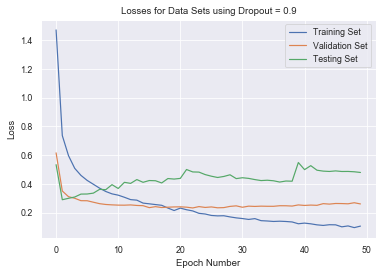

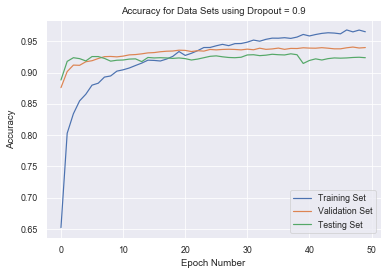

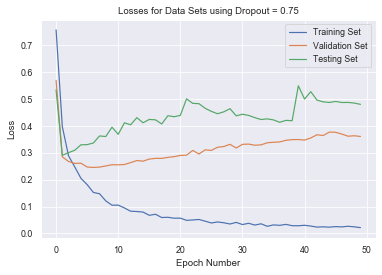

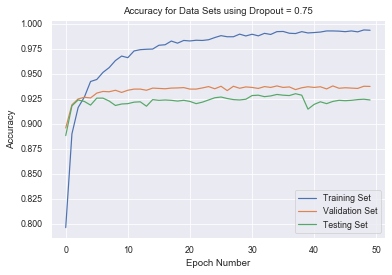

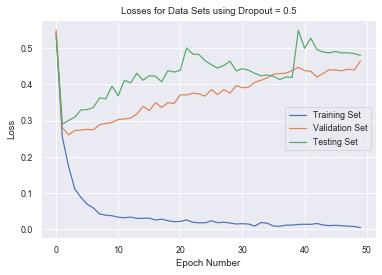

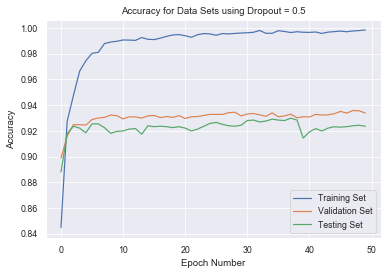

In [34]:
# Plot L2 normalization results
for i, dropout_val in enumerate(dropout_list):
    for j in range(3):
        plt.plot(losses[i][j])
    plt.title('Losses for Data Sets using Dropout = ' + str(dropout_val))
    plt.legend(['Training Set', 'Validation Set', 'Testing Set'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch Number')
    plt.show()
    
    for j in range(3):
        plt.plot(accuracies[i][j])
    plt.title('Accuracy for Data Sets using Dropout = ' + str(dropout_val))
    plt.legend(['Training Set', 'Validation Set', 'Testing Set'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch Number')
    plt.show()

The purpose of dropout is to control overfitting, and ensure that all of the neurons in the network are being used. The graphs above demonstrate this, as there is an appreciable change in the accuracy of the training over time. With higher dropout rates, the training accuracy grows more slowly, which is expected. This should lead to a longer period of time before the network starts to exhibit overfitting.